In [1]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, num_classes=10):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        num_classes: количество случайных классов для выборки
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.num_classes = num_classes

        # Чтение всех классов
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]

        # Выбираем случайные 10 классов
        self.selected_classes = random.sample(self.class_names, self.num_classes)
        self.class_to_idx = {name: i for i, name in enumerate(self.selected_classes)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in self.selected_classes:
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls in self.selected_classes:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:  # Test
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "tiny-imagenet-200"

# Обучающий и валидационный датасеты
train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

# Загрузчики данных
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# Вывод статистики
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Классов: {len(train_dataset.selected_classes)}")


Train size: 5000
Val size: 500
Классов: 10


In [2]:
def print_cls_names(root_dir):
    print("Выбранные классы:")
    with open(os.path.join(root_dir, 'words.txt'), 'r') as f:
        words_strings = [line.strip() for line in f]
        for cls in train_dataset.selected_classes:
            for line in words_strings:
                if line.startswith(cls):
                    print(f"{cls}: {line}")
                    break
print_cls_names(root)

Выбранные классы:
n03026506: n03026506	Christmas stocking
n02165456: n02165456	ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
n03662601: n03662601	lifeboat
n04285008: n04285008	sports car, sport car
n02795169: n02795169	barrel, cask
n01774750: n01774750	tarantula
n02415577: n02415577	bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis
n02504458: n02504458	African elephant, Loxodonta africana
n04070727: n04070727	refrigerator, icebox
n03617480: n03617480	kimono


In [15]:
def print_cls_name_from_code(root_dir,code_name):
    print("Название класса:")
    with open(os.path.join(root_dir, 'words.txt'), 'r') as f:
        words_strings = [line.strip() for line in f]
        for line in words_strings:
            if line.startswith(code_name):
                print(f"{line}")
                break

In [ ]:
import torch
import matplotlib.pyplot as plt
import time

timeout = 60  # Максимальное время ожидания в секундах
start_time = time.time()

while time.time() - start_time < timeout:
    try:
        images, labels = next(iter(train_loader))
        break  # Прерываем, если данные успешно загружены
    except StopIteration:
        print("Ошибка в загрузке данных или итерации")
        break
    if time.time() - start_time > timeout:
        print("Превышено время ожидания. Прерываю выполнение.")
        break

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset.class_names)}")
print(f"Примеры названий классов: {train_dataset.class_names[:5]}")

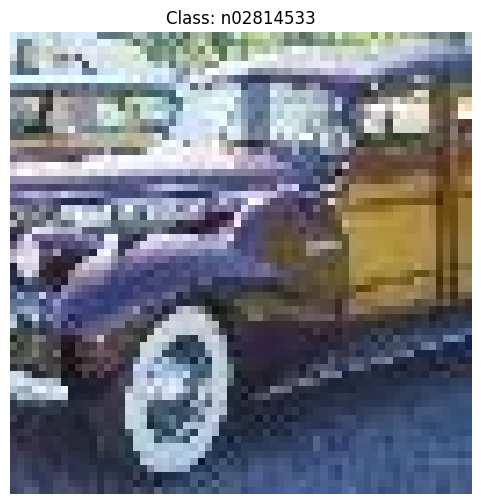

Размер изображения: torch.Size([1, 3, 64, 64])
Метка класса: 7
Название класса:
n02814533	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon


In [16]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

# Преобразования
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Изменяем размер изображения
    transforms.ToTensor(),        # Преобразуем изображение в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализуем
])

# Инициализация датасета и DataLoader
root = "tiny-imagenet-200"
train_dataset = TinyImageNetDataset(root, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Установим batch_size=1

# Получаем одно изображение и метку
images, labels = next(iter(train_loader))

# Денормализация для отображения
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

# Денормализуем изображение
img_vis = denormalize(images[0])

# Визуализация одного изображения
plt.figure(figsize=(6, 6))
plt.imshow(img_vis.numpy())  # Переходим от тензора к NumPy для matplotlib
class_name = train_dataset.selected_classes[labels.item()]  # Получаем имя класса по индексу
plt.title(f"Class: {class_name}")  # Печатаем название класса
plt.axis('off')  # Убираем оси
plt.show()

print(f"Размер изображения: {images.shape}")
print(f"Метка класса: {labels.item()}")  # Выводим индекс метки
print_cls_name_from_code(root,class_name)  # Выводим название класса
